In [2]:
import json
import numpy as np
import pandas as pd
import uproot
import matplotlib.pyplot as plt
import mplhep as mh

from hist.hist import Hist
from hist.axis import Regular
from hist.axis import IntCategory
from hist.axis import StrCategory

from pathlib import Path

from typing import Optional, Union

from matplotlib.colors import Colormap, ListedColormap
from matplotlib.colors import LogNorm

In [3]:
from functools import cache
from functools import cached_property

@cache
def get_segment(ring: int, station: int, sector: int, subsector: int) -> int:
    """
    https://github.com/cms-sw/cmssw/blob/CMSSW_13_3_0_pre3/Geometry/RPCGeometry/src/RPCGeomServ.cc#L361-L368
    """
    nsub = 3 if ring == 1 and station > 1 else 6
    return subsector + nsub * (sector - 1)


@cache
def get_roll_name(region: int, ring: int, station: int, sector: int, layer: int,
             subsector: int, roll: int
) -> str:
    """
    https://github.com/cms-sw/cmssw/blob/CMSSW_13_3_0_pre3/Geometry/RPCGeometry/src/RPCGeomServ.cc#L11-L87
    """
    if region == 0:
        name = f'W{ring:+d}_RB{station}'

        if station <= 2:
            name += 'in' if layer == 1 else 'out'
        else:
            if sector == 4 and station == 4:
                name += ['--', '-', '+', '++'][subsector - 1]
            elif (station == 3) or (station == 4 and sector not in (4, 9, 11)):
                name += '-' if subsector == 1 else '+'
        name += f'_S{sector:0>2d}_'
        name += ['Backward', 'Middle', 'Forward'][roll - 1]
    else:
        segment = get_segment(ring, station, sector, subsector)
        name = f'RE{station * region:+d}_R{ring}_CH{segment:0>2d}_'
        name += ['A', 'B', 'C', 'D', 'E'][roll - 1]
    return name

In [24]:
working_dir = Path('/users/eigen1907/Workspace/Workspace-RPC/240425-TnP_RPC24/TnP_Plotting')
input_path_2022 = working_dir / 'data' / 'Run2022_mean.csv'
input_path_2023 = working_dir / 'data' / 'Run2023_mean.csv'

data2022 = pd.read_csv(input_path_2022, index_col=False)
data2023 = pd.read_csv(input_path_2023, index_col=False)

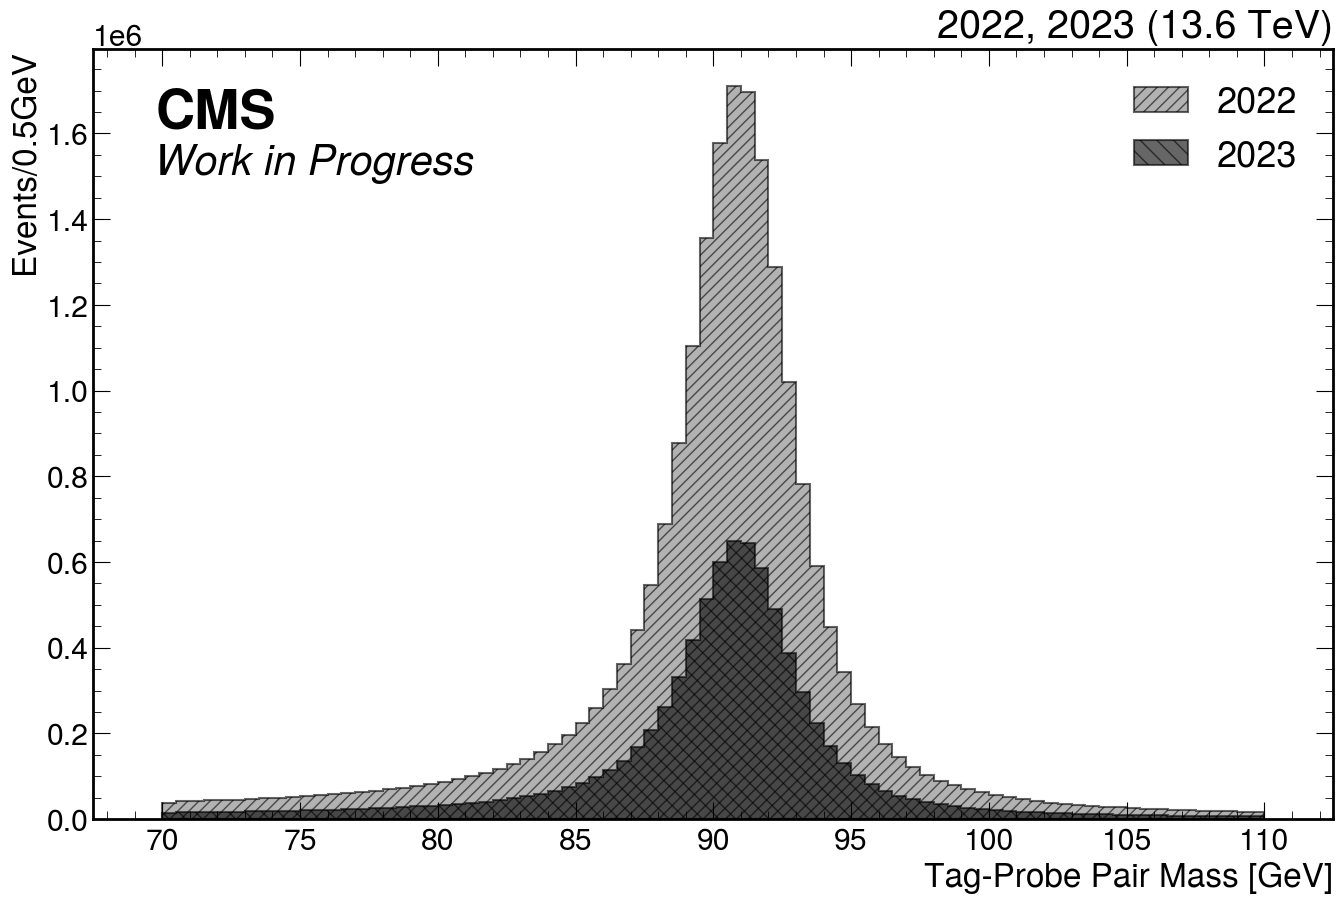

In [31]:
mass2022 = np.array(data2022['dimuon_mass'])
mass2023 = np.array(data2023['dimuon_mass'])

mh.style.use(mh.styles.CMS)
label = "Work in Progress"
com = 13.6

facecolors = ['black', 'black']
edgecolors = ['gray', 'black']
hatch = ['///', '\\\\']

fig, ax = plt.subplots(figsize=(16, 10))
mh.cms.label(ax=ax, data=True, label=label, com=com, year=f"2022, 2023", fontsize=30, loc=2)
ax.set_xlabel('Tag-Probe Pair Mass [GeV]', fontsize=24)
ax.set_ylabel('Events/0.5GeV', fontsize=24)
ax.set_xlim(67.5, 112.5)

hist2022 = Hist(Regular(80, 70, 110))
hist2023 = Hist(Regular(80, 70, 110))

hist2022.fill(mass2022)
hist2023.fill(mass2023)

hist2022.plot(
    ax = ax,
    yerr = False,
    histtype="fill",
    linewidth=1.5,
    flow=None,
    label="2022",
    hatch="///",
    alpha=0.6,
    edgecolor='black',
    facecolor='gray',
    #density=True
)

hist2023.plot(
    ax = ax,
    yerr = False,
    histtype="fill",
    edgecolor='black',
    facecolor='black',
    linewidth=1.5,
    hatch='\\\\',
    flow=None,
    label="2023",
    alpha=0.6,
    #density=True
)

ax.legend(fontsize="26", loc='upper right')

output_dir = working_dir / 'plotting' / 'Hist1D' / 'event-dimumass'

if not output_dir.exists():
    output_dir.mkdir(parents=True)

fig.savefig(output_dir / f"Run3-DiMuonMass.png")

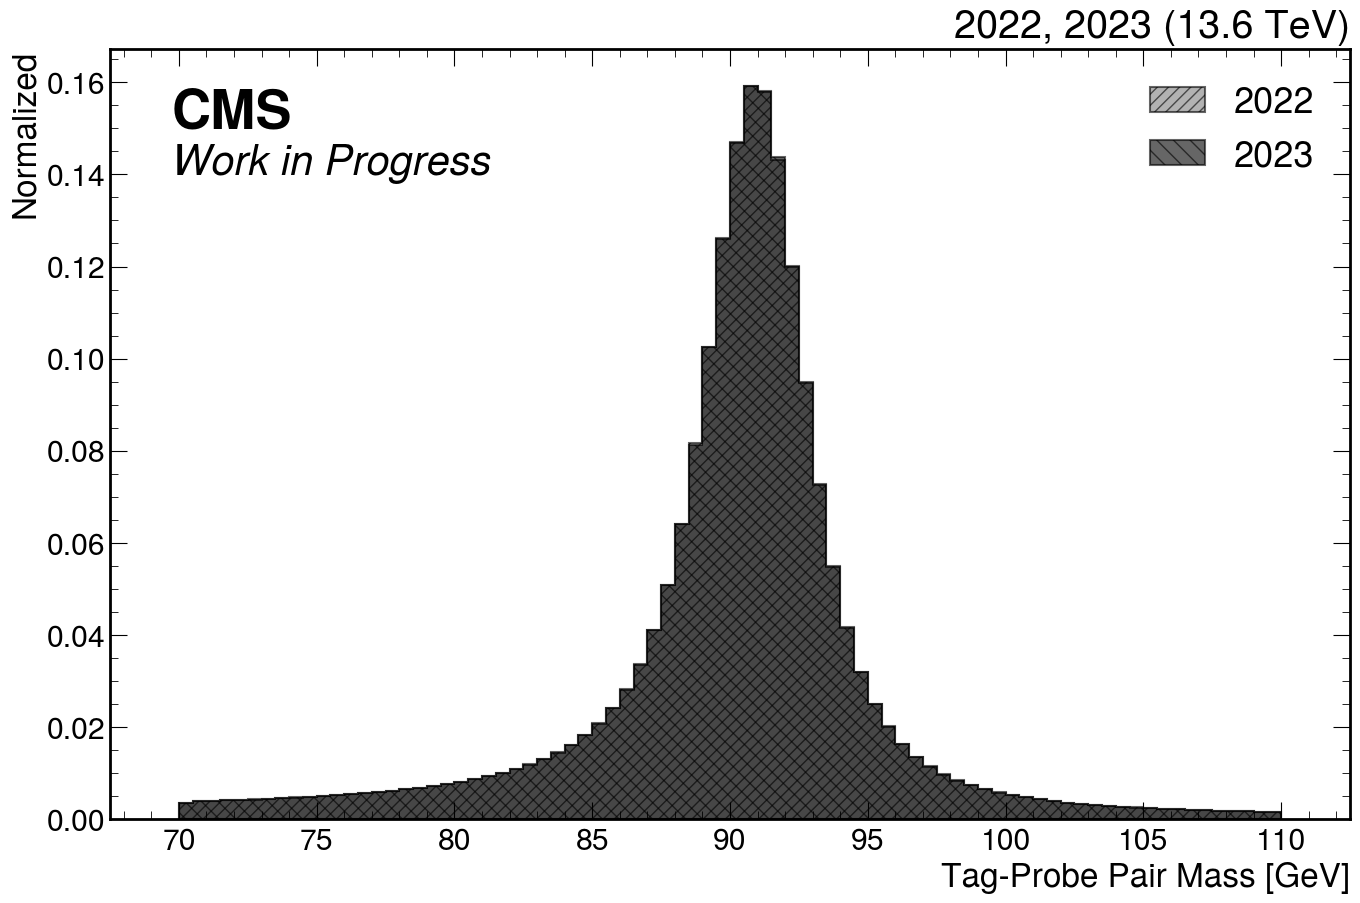

In [32]:
mass2022 = np.array(data2022['dimuon_mass'])
mass2023 = np.array(data2023['dimuon_mass'])

mh.style.use(mh.styles.CMS)
label = "Work in Progress"
com = 13.6

facecolors = ['black', 'black']
edgecolors = ['gray', 'black']
hatch = ['///', '\\\\']

fig, ax = plt.subplots(figsize=(16, 10))
mh.cms.label(ax=ax, data=True, label=label, com=com, year=f"2022, 2023", fontsize=30, loc=2)
ax.set_xlabel('Tag-Probe Pair Mass [GeV]', fontsize=24)
ax.set_ylabel('Normalized', fontsize=24)
ax.set_xlim(67.5, 112.5)

hist2022 = Hist(Regular(80, 70, 110))
hist2023 = Hist(Regular(80, 70, 110))

hist2022.fill(mass2022)
hist2023.fill(mass2023)

hist2022.plot(
    ax = ax,
    yerr = False,
    histtype="fill",
    linewidth=1.5,
    flow=None,
    label="2022",
    hatch="///",
    alpha=0.6,
    edgecolor='black',
    facecolor='gray',
    density=True
)

hist2023.plot(
    ax = ax,
    yerr = False,
    histtype="fill",
    edgecolor='black',
    facecolor='black',
    linewidth=1.5,
    hatch='\\\\',
    flow=None,
    label="2023",
    alpha=0.6,
    density=True
)

ax.legend(fontsize="26", loc='upper right')

output_dir = working_dir / 'plotting' / 'Hist1D' / 'event-dimumass'

if not output_dir.exists():
    output_dir.mkdir(parents=True)

fig.savefig(output_dir / f"Run3-DiMuonMass-Norm.png")